# Develop a Classifier with Logistic Regression

In [37]:
### for file IO:
import os
work_dir = os.getcwd()

import codecs
from sklearn.externals import joblib # for pickling the pipeline

### for data analysis:
import numpy as np
import pandas as pd

### for text cleaning & preprocessing:
import re
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

### for plotting:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

### for vectorizing text & training ML algorithms:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.externals import joblib # for pickling the pipeline

from __future__ import print_function # use print as a function like in python3

## Define functions used for cleaning and tokenizing tweets. 
We can use grid search (later in this script) to find the best combination of parameters.

In [38]:
stop = stopwords.words('english')

def rmURL(tweet):
    #Convert to lower case
    tweet = tweet.lower()
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    return tweet

def rmMARK(tweet):
    tweet = rmURL(tweet)
    #Convert @username to ATusername
    tweet = re.sub('@','AT',tweet)
    #Replace # with HASH_TAG
    tweet = re.sub('#', 'HASH', tweet)
    #Temporarily store emoticons
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', tweet)
    #Remove all non-word charactersand add the emoticons to 
    # the end of the processed document string
    # remove emoticon nose to be consistent
    tweet = re.sub('[\W]+', ' ', tweet) + ' ' + \
            ' '.join(emoticons).replace('-', '')
    #trim
    tweet = tweet.strip('\'"')
    return tweet

def tweetCleaner(tweet):
    tweet = rmURL(tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','AT_USER',tweet)
    #Replace # with HASH_TAG
    tweet = re.sub('#', 'HASH_TAG ', tweet)
    #Temporarily store emoticons
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', tweet)
    #Remove all non-word charactersand add the emoticons to 
    # the end of the processed document string
    # remove emoticon nose to be consistent
    tweet = re.sub('[\W]+', ' ', tweet) + ' ' + \
            ' '.join(emoticons).replace('-', '')
    #trim
    tweet = tweet.strip('\'"')
    return tweet

def rmURLtokenizer(tweet):
    tweet = rmURL(tweet)
    tw = [w for w in tweet.split() if w not in stop]
    return tw

def rmMARKtokenizer(tweet):
    tweet = rmMARK(tweet)
    tw = [w for w in tweet.split() if w not in stop]
    return tw

def tweetTokenizer(tweet):
    tweet = tweetCleaner(tweet)
    tw = [w for w in tweet.split() if w not in stop]
    return tw

porter = PorterStemmer()
def rmURL_porter(text):
    return [porter.stem(word) for word in rmURLtokenizer(text)]

def rmMARK_porter(text):
    return [porter.stem(word) for word in rmMARKtokenizer(text)]

def tokenizer_porter(text):
    return [porter.stem(word) for word in tweetTokenizer(text)]

## Load in the pickled data frame:

In [39]:
df = pd.read_pickle('healthcare_RTbinary_pandasDF.pkl')

In [40]:
pos = df.ix[df['RTbinary'] == 1]
neg = df.ix[df['RTbinary'] == 0]

print(pos.shape)
print(neg.shape)

(28975, 2)
(276330, 2)


Subsample Tweets that were not retweeted to roughly match the total number of tweets that were retweeted, so that the two categories have the same sample size.

In [41]:
negtrain = neg.sample(n = pos.shape[0],random_state=0)
negtest = neg.drop(negtrain.index)

In [42]:
df = pos.append(negtrain)
print(df.shape)

(57950, 2)


In [43]:
# Random Shuffling:
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

In [44]:
df.head()

,RTbinary,tweet
608892,True,RT @IESHealthcare: Pursue a career in emergenc...
33185,False,"Want to work in #Jacksonville, FL? View our la..."
358323,False,"""Earn attractive honorarium by taking medical ..."
373739,True,"RT @carrollu: Welcome to @Donn_DimondPT '98, o..."
348749,True,I don't want the NHS to spend its time on immi...


## Train / Test Split:
Split the roughly balanced dataset into train and test datasets:

In [68]:
X_train, X_test, y_train, y_test = train_test_split(df.tweet.values,df.RTbinary.values, train_size = 0.8,random_state=0)

Use Scikit Learn GridSearch and Cross-validatoin to optimize the TFxIDF vectorization parameters including N-gram range, stopword list, tokenization, stemming, as well as logistic regression penalty and regularization. 

In [25]:
tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None)
from sklearn.ensemble import RandomForestClassifier
param_grid = [
    {'vect__ngram_range': [(1,2),(1,3)],
     'vect__stop_words': [stop, None],
     'vect__tokenizer': [rmURLtokenizer, rmMARKtokenizer, tweetTokenizer, 
                         rmURL_porter, rmMARK_porter, tokenizer_porter],
     'clf__penalty': ['l1', 'l2'],
     'clf__C': [1.0, 10.0, 100.0]},
    {'vect__ngram_range': [(1,2),(1,3)],
     'vect__stop_words': [stop, None],
     'vect__tokenizer': [rmURLtokenizer, rmMARKtokenizer, tweetTokenizer, 
                         rmURL_porter, rmMARK_porter, tokenizer_porter],
     'vect__use_idf':[False],
     'vect__norm':[None],
     'clf__penalty': ['l1', 'l2'],
     'clf__C': [1.0, 10.0, 100.0]}
] 

lr_tfidf = Pipeline([ ('vect', tfidf), ('clf', LogisticRegression(random_state=0)) ])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid, scoring='accuracy',
                           cv=5, verbose=1, n_jobs=-1)

gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 114.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 141.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 183.8min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 216.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('vect', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=Tru...nalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'vect__ngram_range': [(1, 2), (1, 3)], 'vect__tokenizer': [<function rmURLtokenizer at 0x7f268270c0c8>, <function rmMARKtokenizer at 0x7f268270c140>, <function tweetTokenizer at 0x7f268270c1b8>, <function rmURL_porter at 0x7f268270c230>, <function rmMARK_porter at 0x7f268270c2a8>, <func...268270c320>], 'vect__use_idf': [False], 'clf__C': [1.0, 10.0, 100.0], 'clf__penalty': ['l1', 'l2']}],
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=1

## Evaluate the model performance using Test dataset

In [26]:
print('Best parameter set: %s' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

pct = float(sum(y_test))/len(y_test)
print('Random Chance Accuracy in Test Set: %.3f' % pct)

Best parameter set: {'vect__ngram_range': (1, 3), 'vect__tokenizer': <function rmURLtokenizer at 0x7f268270c0c8>, 'vect__stop_words': [u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'whe

In [27]:
y_pred = clf.predict(X_test)

In [28]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.title(title, fontsize = 18)
    plt.colorbar()
    tick_marks = [0,1] 
    plt.xticks(tick_marks, fontsize = 14) 
    plt.yticks(tick_marks, fontsize = 14) 
    plt.tight_layout()
    plt.ylabel('True Labels', fontsize = 16)
    plt.xlabel('Predicted Labels', fontsize= 16)

In [29]:
labels = [0, 1]
cm = confusion_matrix(y_test, y_pred, labels)

Normalized confusion matrix
[[ 0.86  0.14]
 [ 0.24  0.76]]


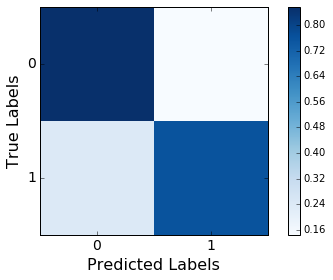

In [30]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
img = 'normCM.png'
plt.tight_layout()

In [32]:
cls_report = classification_report(y_test, y_pred, labels) 
print(cls_report)

             precision    recall  f1-score   support

          0       0.78      0.86      0.82      5796
          1       0.84      0.76      0.80      5794

avg / total       0.81      0.81      0.81     11590



### When the test set is balanced between the two classes, the algorithms perform pretty well. In real world, there are many more tweets that are not retweeted than those that get retweets. Combine the test dataset with the unused tweets from the negative class to form an imbalanced dataset to test the performance of the model:

In [52]:
X_allTest = np.append(X_test, negtest.tweet.values)
y_allTest = np.append(y_test, negtest.RTbinary.values)

In [55]:
clf = joblib.load('classifier_healthcare_logit.pkl')

In [57]:
y_allPred = clf.predict(X_allTest)

In [75]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.title(title, fontsize = 18)
    plt.colorbar()
    tick_marks = [0,1] #np.arange(len(iris.target_names))
    plt.xticks(tick_marks, fontsize = 14) #(tick_marks, iris.target_names, rotation=45)
    plt.yticks(tick_marks, fontsize = 14) # (tick_marks, iris.target_names)
    plt.tight_layout()
    plt.ylabel('True Labels', fontsize = 16)
    plt.xlabel('Predicted Labels', fontsize= 16)

In [66]:
labels = [False, True]
cm = confusion_matrix(y_allTest==1, y_allPred==1, labels)

Normalized confusion matrix
[[ 0.86  0.14]
 [ 0.24  0.76]]


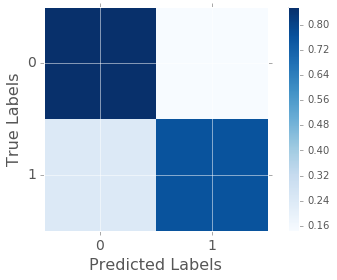

In [76]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
img = 'normCM.png'
plt.tight_layout()

### The normalized confusoin matrix shows that the classifier works well within each class (86% accuracy for non-retweeted, and 76% for retweeted tweets).

In [61]:
cls_report = classification_report(y_allTest, y_allPred, labels) 
print(cls_report)

             precision    recall  f1-score   support

          0       0.99      0.86      0.92    253151
          1       0.11      0.76      0.19      5794

avg / total       0.97      0.85      0.90    258945



### The precision for the retweeted class is very low, making the F1-score low. Adjusting the threshold for the prediction might improve the performance. 

In [33]:
joblib.dump(clf, 'classifier_healthcare_logit.pkl', compress = 1)

['classifier_healthcare_logit.pkl']

### Pre-process the data and save it for training logistic regression with stochastic gradient descent. 

In [45]:
#df.drop(df.index[bad_tweets],inplace=True)
tweets = df['tweet'].values
texts = []
tokes = []
bad_tweets = []

for i in range(len(tweets)):
    try:
        texts.append(tweetCleaner(tweets[i]))
        tokes.append(tokenizer_porter(tweets[i]))
    except:
        print (i)
        bad_tweets.append(i)

Save the cleaned tweet data to use for training and testing the logistic regression with stochastic gradient descent:

In [46]:
df['cleanTweet'] = texts
df['tokenTweet'] = tokes

path = 'rtBinaryClean.csv'
dfClean = pd.DataFrame({"RTbinary": df.RTbinary * 1, "cleanTweet": df.cleanTweet})
dfClean.to_csv(path, index=False, header=False)